Imports

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

1. Basic Cleaning and Creating Train/Test Split


In [8]:
raw_data = pd.read_csv('/content/car_insurance_claim.csv')

In [9]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban



1.2 Basic Data Cleaning

In [10]:
# Create new copy of data
data_df = raw_data.copy()

In [12]:
# Define updated column names
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}
data_df.rename(columns=col_names, inplace=True)

In [13]:

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [14]:

# Check number of duplicate records
data_df.duplicated().sum()

np.int64(1)

In [15]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

In [16]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

In [17]:

data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [18]:

data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban



1.3 Create Train/Test Split

In [19]:
mask = (data_df['new_claim_value'] > 0) & (data_df['is_claim'] == 0)
data_df[mask]

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type


<Axes: xlabel='new_claim_value', ylabel='Count'>

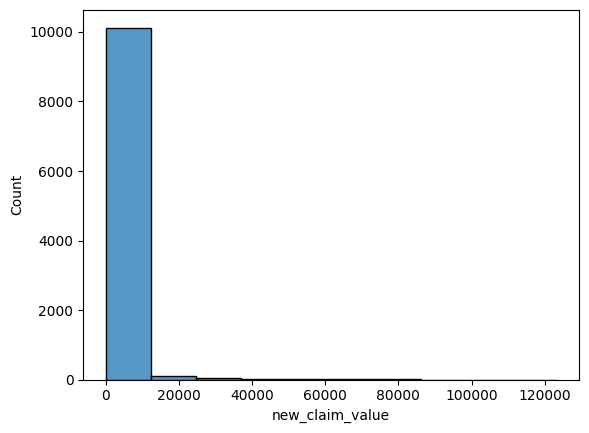

In [20]:

# Create hisogram for new claim value
sns.histplot(data_df['new_claim_value'], bins=10)

In [21]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='claim_value_cat'>

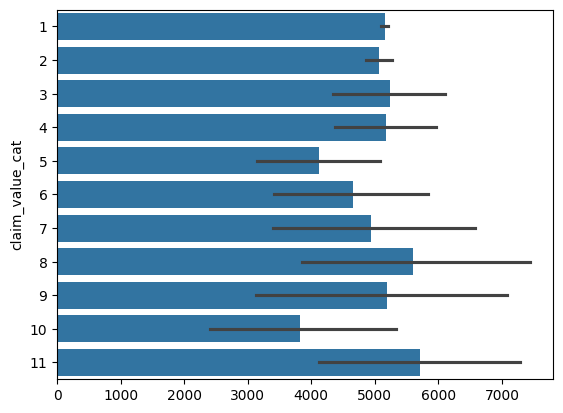

In [22]:
sns.barplot(data_df['claim_value_cat'])

In [23]:
# Create clean copy of training data
X = data_df.copy()
y = data_df['is_claim']

# Drop the target feature
X.drop(columns=['new_claim_value','is_claim'], inplace=True)

# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

In [24]:
train_ratio = round((y_train.sum()/len(y_train))*100,2)
test_ratio = round((y_test.sum()/len(y_test)*100),2)

print(f'Train positive class ratio: {train_ratio}%')
print(f'Test positive class ratio: {test_ratio}%')

Train positive class ratio: 26.62%
Test positive class ratio: 26.78%


In [25]:
for set_ in (X_train, X_test):
    set_.drop(columns=['claim_value_cat'], inplace=True)


2. Exploratory Data Analysis (EDA)


2.1 Preparation

In [26]:

# Create a new copy of X_train for the analysis
eda_test_data = X_train.copy()
eda_test_data['is_claim'] = y_train

In [27]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)

In [28]:
# Check updated values
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
6826,0,43.0,2,13.0,27684,0,121310,1,1,Masters,Lawyer,11,Private,13250,10,Minivan,1,0,0,0,0,10.0,Highly Urban/ Urban,0
5879,0,46.0,0,12.0,132651,0,340258,1,0,Masters,Professional,11,Private,1500,3,SUV,0,0,0,0,1,12.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8864,0,50.0,0,11.0,53567,0,225043,1,1,<High School,Blue Collar,15,Commercial,27630,1,Panel Truck,0,0,0,0,2,8.0,Highly Urban/ Urban,0



2.2 Correlation Matrix

In [29]:
eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,commute_dist,vehicle_value,policy_tenure,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,is_claim
is_claim,0.107682,-0.104518,0.125717,-0.054093,-0.145554,0.153925,-0.192158,-0.132422,-0.020189,0.043795,-0.104157,-0.083386,-0.006349,0.149505,0.226031,0.159961,0.219370,-0.113847,1.000000
5_year_num_of_claims,0.035509,-0.039158,0.040629,-0.026706,-0.046731,0.059716,-0.097332,-0.072154,0.014772,0.008400,-0.034667,-0.013218,0.025276,0.489628,1.000000,0.055732,0.404196,-0.025045,0.226031
license_points,0.052236,-0.077434,0.069676,-0.041635,-0.068195,0.073639,-0.100863,-0.053613,-0.003957,0.007020,-0.054596,-0.033003,0.005567,0.267522,0.404196,0.054956,1.000000,-0.037811,0.219370
licence_revoked,0.038997,-0.044826,0.048659,-0.006859,-0.030609,0.048588,-0.047458,-0.037797,-0.024419,0.003593,-0.032153,-0.030761,-0.017447,0.426035,0.055732,1.000000,0.054956,-0.026676,0.159961
single_parent,0.205570,-0.310859,0.453904,-0.026786,-0.069457,1.000000,-0.248129,-0.474850,-0.059510,-0.013267,-0.042035,0.009812,-0.037777,0.042506,0.059716,0.048588,0.073639,-0.064610,0.153925
5_year_total_claims_value,0.034944,-0.041693,0.047909,-0.005046,-0.050069,0.042506,-0.068386,-0.042935,-0.009581,-0.014566,-0.035501,-0.013356,0.005878,1.000000,0.489628,0.426035,0.267522,-0.031843,0.149505
num_of_children,0.462739,-0.450469,1.000000,0.078220,-0.160348,0.453904,-0.106909,0.040934,-0.113134,0.000998,-0.108963,0.012454,-0.071393,0.047909,0.040629,0.048659,0.069676,-0.155284,0.125717
num_young_drivers,1.000000,-0.077894,0.462739,0.035620,-0.048903,0.205570,-0.022280,0.037149,-0.041939,0.016301,-0.028264,-0.003096,-0.045963,0.034944,0.035509,0.038997,0.052236,-0.063605,0.107682
commute_dist,0.016301,0.003272,0.000998,-0.008748,-0.052348,-0.013267,-0.033258,0.003615,-0.008889,1.000000,-0.025168,-0.003361,0.015105,-0.014566,0.008400,0.003593,0.007020,-0.036895,0.043795
red_vehicle,-0.045963,0.027402,-0.071393,0.053686,0.058497,-0.037777,0.023565,-0.019238,0.664188,0.015105,0.027925,-0.009364,1.000000,0.005878,0.025276,-0.017447,0.005567,0.010583,-0.006349


<Axes: >

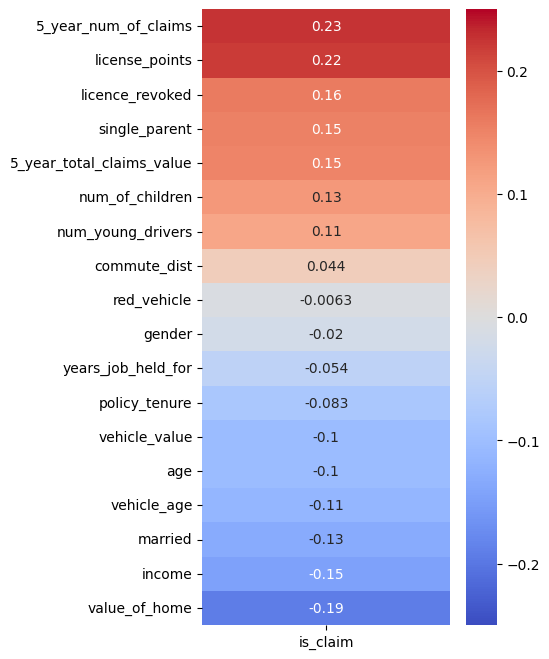

In [30]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)


3. Data Cleaning and Preprocessing

3.1 Dropping Features

In [31]:
X_train_raw = X_train.copy()

cols_to_drop = [
    'red_vehicle',
]

X_train_raw.drop(columns=cols_to_drop, axis=1, inplace=True)


3.2 Handling Missing Values

In [32]:
# Check the number of missing values in each row
X_train_raw.isnull().sum().sum()

np.int64(2402)

In [33]:

# Check how many missing values there are in each feature
X_train_raw.isnull().sum()

,0
num_young_drivers,0
age,5
num_of_children,0
years_job_held_for,427
income,477
single_parent,0
value_of_home,457
married,0
gender,0
highest_education,0


In [34]:
# Create the imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Define the numerical columns
numerical_cols_df = X_train_raw.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Define the categorial columns for use later
cat_cols_df = X_train_raw.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [35]:
# Define function to impute num features using KNN
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute numerical values with knn
num_test_data_imputed = num_knn_impute(X_train_raw, numerical_cols, knn_imputer)

In [36]:
# Get numerical cols as a df
num_cols_df = X_train_raw[numerical_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
7,0,44.0,0,NaN,0,0,27,5900,4,0,0,2,11.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
15,0,56.0,2,NaN,99186,336691,35,16820,3,0,0,1,9.0
17,0,44.0,0,12.0,<NA>,228990,39,12180,1,0,0,2,1.0
19,0,32.0,3,14.0,<NA>,128776,34,6890,1,36000,4,1,NaN


In [37]:

# Show same records after imputation
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age
7,0.0,44.0,0.0,0.0,0.0,0.0,27.0,5900.0,4.0,0.0,0.0,2.0,11.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
15,0.0,56.0,2.0,7.5,99186.0,336691.0,35.0,16820.0,3.0,0.0,0.0,1.0,9.0
17,0.0,44.0,0.0,12.0,69647.0,228990.0,39.0,12180.0,1.0,0.0,0.0,2.0,1.0
19,0.0,32.0,3.0,14.0,36642.5,128776.0,34.0,6890.0,1.0,36000.0,4.0,1.0,7.0


In [38]:
# Create the imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Define function to impute cat features using simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Run the function to impute missing categorical values
cat_test_data_imputed = cat_simple_imputer(X_train_raw, cat_cols, simple_imputer)

In [39]:

# Get numerical cols as a df
cat_cols_df = X_train_raw[cat_cols].reset_index(drop=True)
# Select rows with missing values and show head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
7,No,No,F,Masters,Home Maker,Private,SUV,No,Highly Urban/ Urban
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
15,No,Yes,M,Bachelors,Manager,Commercial,Van,No,Highly Urban/ Urban
17,No,No,M,<High School,Clerical,Private,Pickup,No,Highly Rural/ Rural
19,No,Yes,F,<High School,Blue Collar,Private,Sports Car,Yes,Highly Urban/ Urban


In [40]:

# Show same records after imputation
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
7,No,No,F,Masters,Home Maker,Private,SUV,No,Highly Urban/ Urban
11,Yes,No,M,High School,Clerical,Private,Pickup,No,Highly Urban/ Urban
15,No,Yes,M,Bachelors,Manager,Commercial,Van,No,Highly Urban/ Urban
17,No,No,M,<High School,Clerical,Private,Pickup,No,Highly Rural/ Rural
19,No,Yes,F,<High School,Blue Collar,Private,Sports Car,Yes,Highly Urban/ Urban


In [41]:

# Rejoin dfs
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# Check head
train_imputed_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,single_parent,married,gender,highest_education,occupation,type_of_use,vehicle_type,licence_revoked,address_type
0,0.0,43.0,2.0,13.0,27684.0,121310.0,11.0,13250.0,10.0,0.0,0.0,0.0,10.0,No,Yes,M,Masters,Lawyer,Private,Minivan,No,Highly Urban/ Urban
1,0.0,46.0,0.0,12.0,132651.0,340258.0,11.0,1500.0,3.0,0.0,0.0,1.0,12.0,No,Yes,F,Masters,Professional,Private,SUV,No,Highly Urban/ Urban
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban
4,0.0,50.0,0.0,11.0,53567.0,225043.0,15.0,27630.0,1.0,0.0,0.0,2.0,8.0,No,Yes,M,<High School,Blue Collar,Commercial,Panel Truck,No,Highly Urban/ Urban


In [42]:
train_imputed_df.isnull().sum()

,0
num_young_drivers,0
age,0
num_of_children,0
years_job_held_for,0
income,0
value_of_home,0
commute_dist,0
vehicle_value,0
policy_tenure,0
5_year_total_claims_value,0



3.4. Categorical Feature Encoding

In [43]:

cat_test_data_imputed.nunique()

,0
single_parent,2
married,2
gender,2
highest_education,5
occupation,8
type_of_use,2
vehicle_type,6
licence_revoked,2
address_type,2


In [44]:
# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

In [45]:
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal encoder
ord_encoder = OrdinalEncoder(categories=education_rank)

# Define binary encoder
bin_encoder = OrdinalEncoder()

# Define one-host encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [46]:
# Encode ordinals
ord_encoded = ord_encoder.fit_transform(cat_test_data_imputed[cat_cols_ord])

# Encode binaries
bin_encoded = bin_encoder.fit_transform(cat_test_data_imputed[cat_cols_bin])

# One-hot encoding
one_hot_encoded = one_hot_encoder.fit_transform(cat_test_data_imputed[cat_cols_one_hot])

In [47]:
# Create dfs for each array
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = cat_cols_ord

bin_encoded_df = pd.DataFrame(bin_encoded)
bin_encoded_df.columns = cat_cols_bin

one_hot_encoded_df = pd.DataFrame(one_hot_encoded)
one_hot_encoded_df.columns = one_hot_encoder.get_feature_names_out()

# Join encoded dfs to a single df and show head
all_cat_encoded_df = pd.concat([ord_encoded_df, bin_encoded_df, one_hot_encoded_df], axis=1)
all_cat_encoded_df.head()

,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [48]:
# Join numerical and categorical data
X_train_cleaned = pd.concat([train_imputed_df[numerical_cols], all_cat_encoded_df], axis=1)

In [49]:

# Check df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Minivan,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,0.0,43.0,2.0,13.0,27684.0,121310.0,11.0,13250.0,10.0,0.0,0.0,0.0,10.0,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,46.0,0.0,12.0,132651.0,340258.0,11.0,1500.0,3.0,0.0,0.0,1.0,12.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,29.0,2.0,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,46.0,1.0,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,50.0,0.0,11.0,53567.0,225043.0,15.0,27630.0,1.0,0.0,0.0,2.0,8.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [50]:

# Function to calculate VIF
def calculate_vif(dataframe):
    # Add a constant to the DataFrame (intercept term)
    df_with_constant = add_constant(dataframe)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                       for i in range(df_with_constant.shape[1])]

    return vif_data

# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,0.000000
1,num_young_drivers,1.320064
2,age,1.473197
3,num_of_children,2.086525
4,years_job_held_for,1.437822
5,income,2.658647
6,value_of_home,2.130919
7,commute_dist,1.039504
8,vehicle_value,2.030324
9,policy_tenure,1.005936


In [51]:
X_train_cleaned.drop(['occupation_Blue Collar' ,'vehicle_type_Minivan'], axis=1, inplace=True)

In [52]:
# Calculate VIF for encoded data
vif_df = calculate_vif(X_train_cleaned)
vif_df

,Feature,VIF
0,const,80.232976
1,num_young_drivers,1.320064
2,age,1.473197
3,num_of_children,2.086525
4,years_job_held_for,1.437822
5,income,2.658647
6,value_of_home,2.130919
7,commute_dist,1.039504
8,vehicle_value,2.030324
9,policy_tenure,1.005936



5. Model Selection - Classfication

In [53]:
# Define the classifiers to test
clfs = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [54]:
# Create KFold object with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
results = {}

# Evaluate each classifier using cross-validation
for clf_name, clf in clfs:
    cv_scores = cross_val_score(clf, X_train_cleaned, y_train, cv=kf)
    results[clf_name] = cv_scores

cv_scores_df = pd.DataFrame(results)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Text(0.5, 1.0, 'Cross-Validation Scores for Different Classifiers')

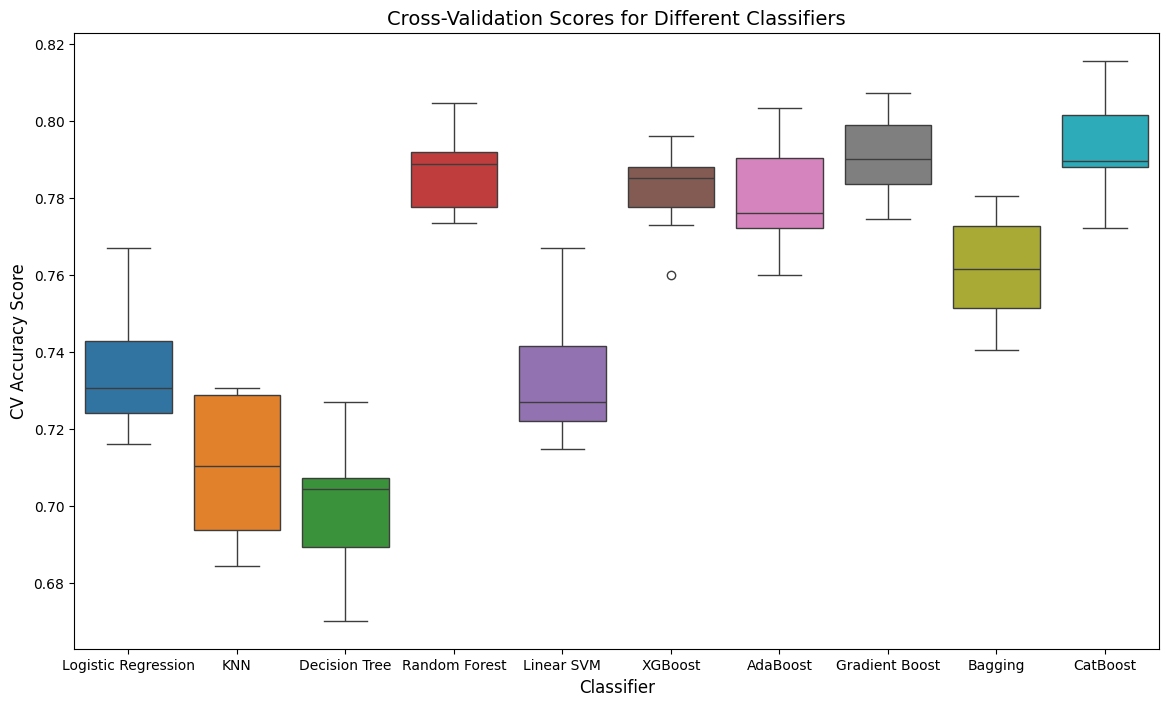

In [55]:
# Plot scores
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(cv_scores_df)

# Add axis labels
ax.set_xlabel('Classifier', fontsize=12)
ax.set_ylabel('CV Accuracy Score', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Classifiers', fontsize=14)


6. Feature Engineering

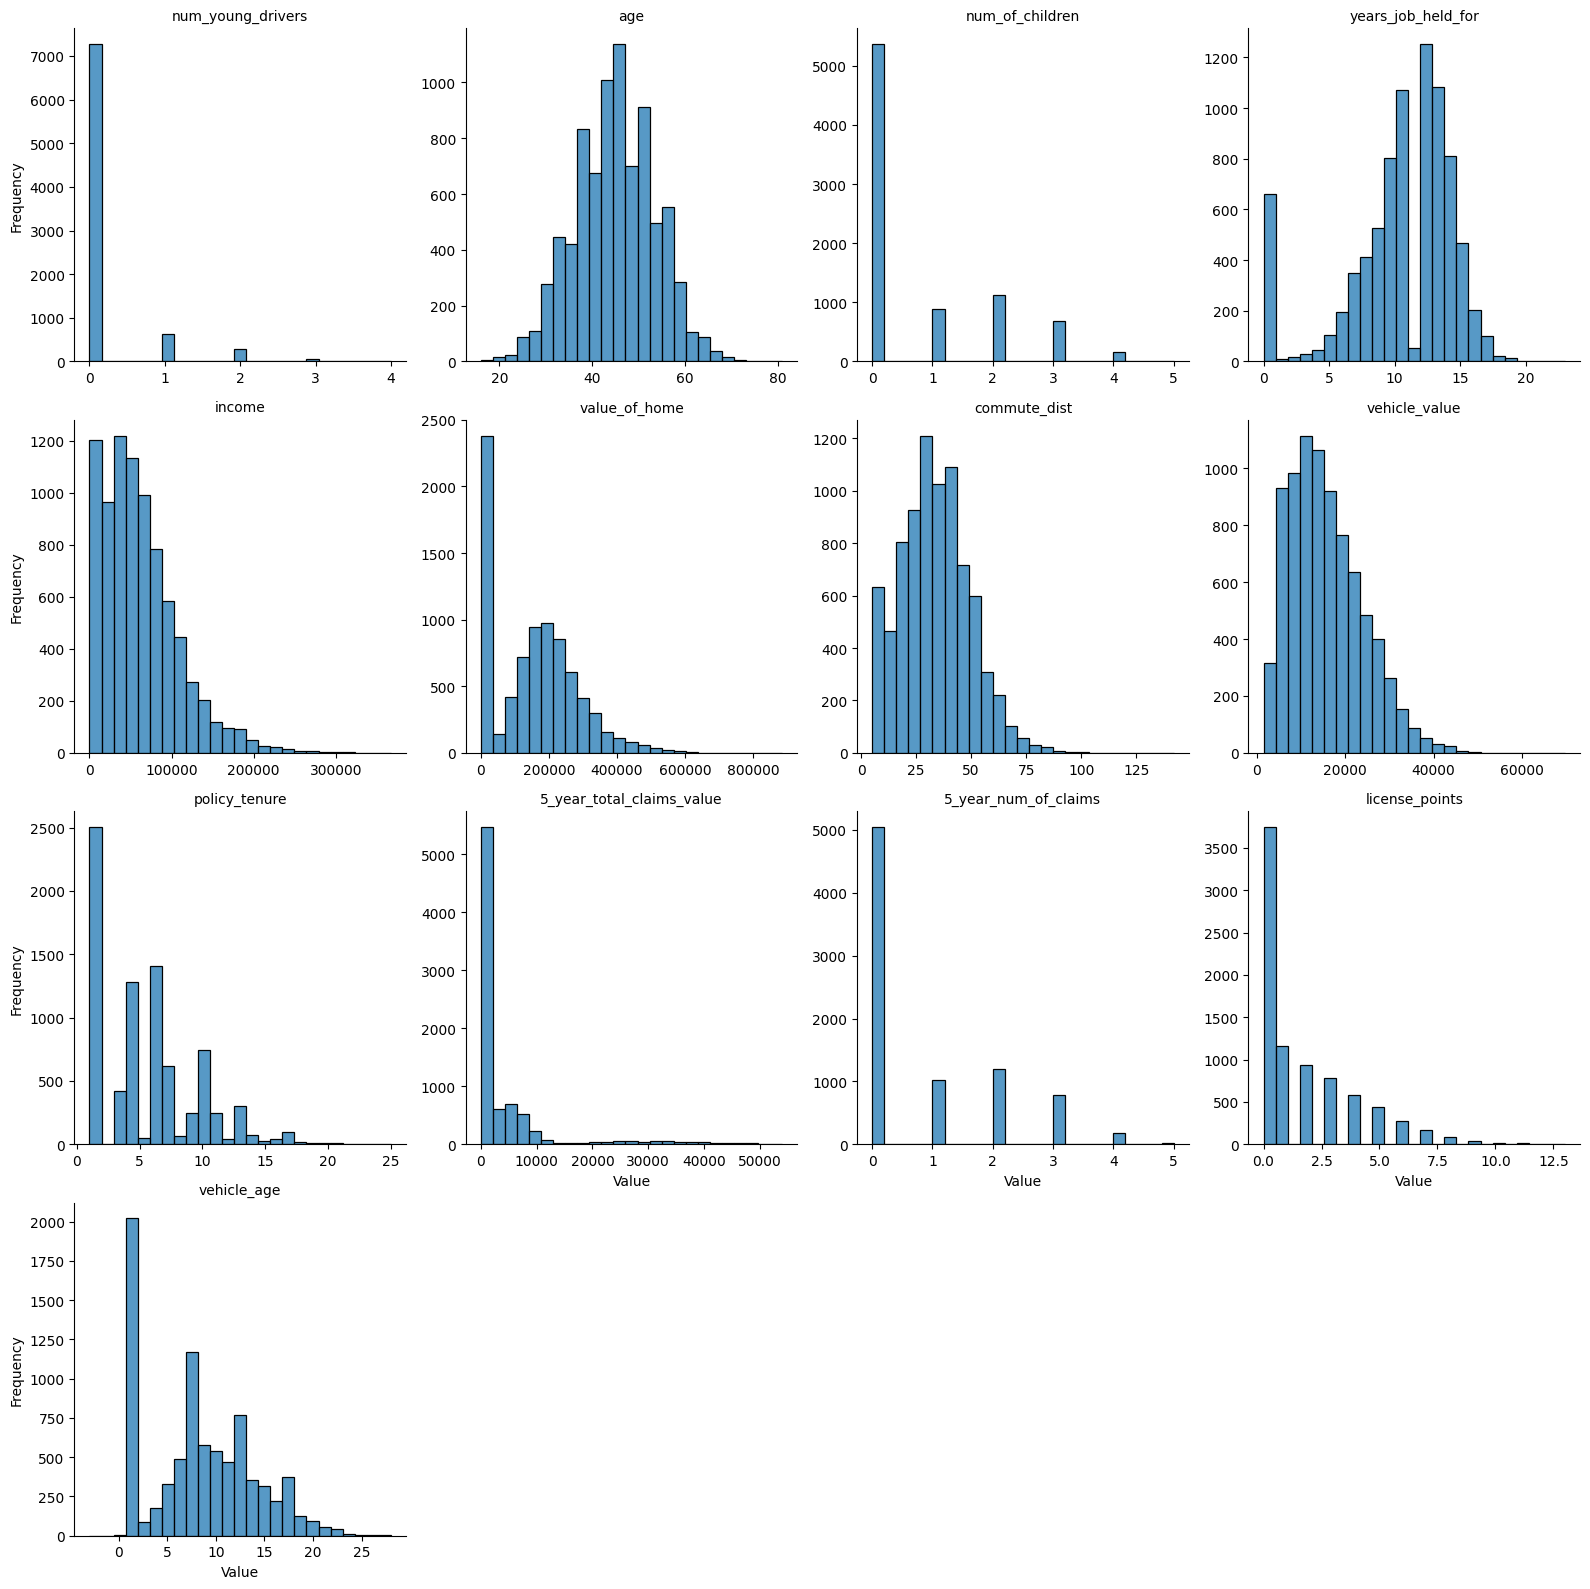

In [56]:

# Melt the DataFrame to long format
melted_X_train = X_train_cleaned[numerical_cols].melt(var_name='Column', value_name='Value')

# Create a FacetGrid
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map the sns.histplot to each facet
g.map(sns.histplot, 'Value', bins=25)

# Add titles and labels
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()
plt.show()

In [57]:
# Define features we right skew
skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define function to apply log transform
def log_of_feature(data_df, skewed_features):
    data = data_df.copy()
    for feature in skewed_features:
        data[feature] = np.sqrt(data[feature])
    return data

# Apply the function to X_train
X_train_cleaned_log = log_of_feature(X_train_cleaned, skewed_features)

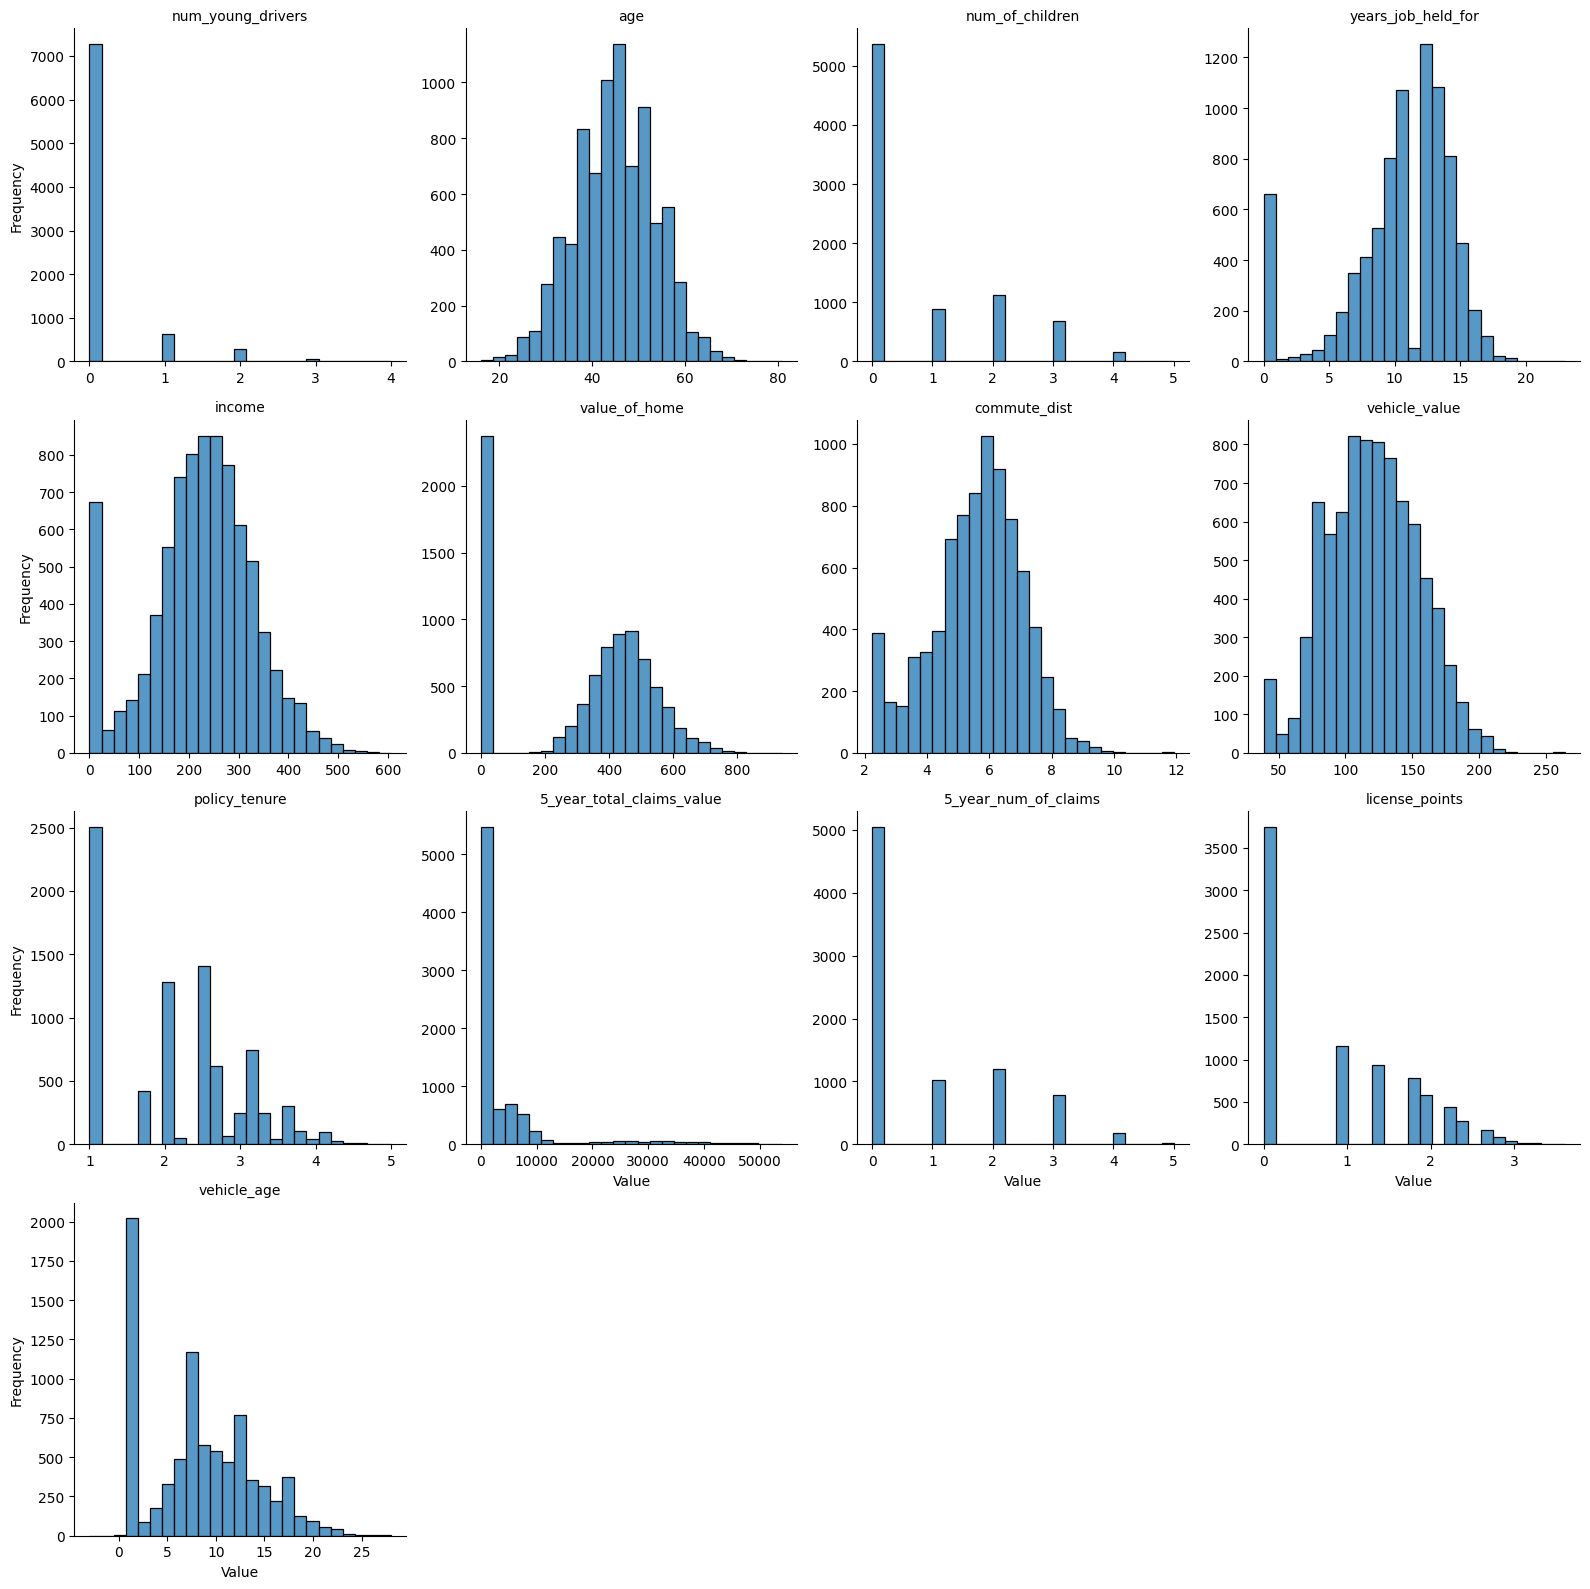

In [58]:

melted_X_train = X_train_cleaned_log[numerical_cols].melt(var_name='Column', value_name='Value')
g = sns.FacetGrid(melted_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, 'Value', bins=25)
g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')
plt.tight_layout()
plt.show()

In [59]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_log = cross_val_score(xgb_boost_clf, X_train_cleaned_log, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_log.mean()}')

CV score without log transform: 0.7821893203883495
CV score with log transform: 0.7821893203883495


In [60]:
# Define function to scale numeric features
def scale_features(data_df, numeric_features):
    data = data_df.copy()
    # Initialise scaler
    scaler = StandardScaler()
    # Fit scaler to training data
    scaler.fit(data[numeric_features])
    # Transform numeric features
    data[numeric_features] = scaler.transform(data[numeric_features])
    return data

# Apply the function to X_train
X_train_cleaned_scaled = scale_features(X_train_cleaned_log, numerical_cols)

In [61]:
xgb_boost_clf = XGBClassifier(random_state=42)

cv_scores = cross_val_score(xgb_boost_clf, X_train_cleaned, y_train, cv=kf)
cv_scores_scaled = cross_val_score(xgb_boost_clf, X_train_cleaned_scaled, y_train, cv=kf)

print(f'CV score without log transform: {cv_scores.mean()}')
print(f'CV score with log transform: {cv_scores_scaled.mean()}')

CV score without log transform: 0.7821893203883495
CV score with log transform: 0.7821893203883495


In [62]:
X_train_cleaned = X_train_cleaned_scaled.copy()



7. Model Pipeline

7.1. Custom Transformers

In [63]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)

    def get_feature_names_out(self, input_features=None):
        return None

In [64]:

class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features


7.2. Pipelines

In [65]:

from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [66]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot),
])

In [71]:

X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [72]:
# Create df from processed data
X_train_prepared_df = pd.DataFrame(
    X_train_prepared,
    columns=preprocess_pipeline.get_feature_names_out(),
)

# Get names of new one-hot columns
one_hot_col_names = list(preprocess_pipeline.transformers_[4][1][1].get_feature_names_out(cat_cols_one_hot))

# Create list of all columns names
new_col_names = numerical_cols + cat_cols_ord + cat_cols_bin + one_hot_col_names

# Rename df columns
X_train_prepared_df.columns = new_col_names

# Reset index
X_train_prepared_df.reset_index(drop=True, inplace=True)

# Inspect df
X_train_prepared_df.head()


,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332302,-0.220417,1.152864,0.628022,-0.539139,0.113859,-1.564515,-0.155862,1.138666,-0.460220,-0.691559,-0.984461,0.303542,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.332302,0.128164,-0.642950,0.382463,1.327604,1.170262,-1.564515,-2.398212,-0.437810,-0.460220,-0.691559,0.087699,0.659804,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.332302,-1.847132,1.152864,0.382463,0.089878,0.424027,0.440818,-2.398212,-0.142461,0.162309,0.176286,1.412962,-0.408981,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332302,0.128164,0.254957,0.628022,0.257142,0.569404,-0.930385,0.844938,-1.244717,0.147489,0.176286,1.641784,-0.408981,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332302,0.592940,-0.642950,0.136903,0.074784,0.680631,-1.183524,1.344760,-1.244717,-0.460220,-0.691559,0.531802,-0.052719,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [73]:
# Inspect manually created df
X_train_cleaned.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,value_of_home,commute_dist,vehicle_value,policy_tenure,5_year_total_claims_value,5_year_num_of_claims,license_points,vehicle_age,highest_education,single_parent,married,gender,type_of_use,licence_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,vehicle_type_Panel Truck,vehicle_type_Pickup,vehicle_type_SUV,vehicle_type_Sports Car,vehicle_type_Van
0,-0.332302,-0.220417,1.152864,0.628022,-0.539139,0.113859,-1.564515,-0.155862,1.138666,-0.460220,-0.691559,-0.984461,0.303542,3.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.332302,0.128164,-0.642950,0.382463,1.327604,1.170262,-1.564515,-2.398212,-0.437810,-0.460220,-0.691559,0.087699,0.659804,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.332302,-1.847132,1.152864,0.382463,0.089878,0.424027,0.440818,-2.398212,-0.142461,0.162309,0.176286,1.412962,-0.408981,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.332302,0.128164,0.254957,0.628022,0.257142,0.569404,-0.930385,0.844938,-1.244717,0.147489,0.176286,1.641784,-0.408981,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.332302,0.592940,-0.642950,0.136903,0.074784,0.680631,-1.183524,1.344760,-1.244717,-0.460220,-0.691559,0.531802,-0.052719,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0



8. Hyperparamter Optimisation

8.1. Random Search

In [74]:
# Define the parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': randint(low=50, high=300),
    'learning_rate':uniform(0.01, 0.29),
    'max_depth': randint(low=1, high = 20),
    'subsample': uniform(0, 1),
    'colsample_bytree': uniform(0, 1),
    'min_child_weight': randint(low=1, high= 20),
    'reg_alpha': randint(low=0, high=100),
    'reg_lambda':randint(low=0, high=10),
    'gamma': uniform(0, 1),
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=2000,  # Increased number of iterations
    scoring=scorer,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [75]:

# Fit the model using RandomizedSearchCV
random_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9792482787019853), 'gamma': np.float64(0.9598343813988768), 'learning_rate': np.float64(0.10544964461126329), 'max_depth': 15, 'min_child_weight': 18, 'n_estimators': 97, 'reg_alpha': 8, 'reg_lambda': 0, 'subsample': np.float64(0.6242904007832697)}
Best cross-validation score:  0.7811841551625942


8.2. Grid Search

In [76]:

# Define the parameter grid with expanded ranges
xgb_param_grid_grid_search = {
    'n_estimators': [280, 290, 300],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.03, 0.04, 0.05],
    'subsample': [0.45, 0.5, 0.55],
    'colsample_bytree': [0.5, 0.55, 0.6],
    'gamma': [0.05, 0.1, 0.15],
    'min_child_weight': [18],
    'reg_alpha': [1],
    'reg_lambda': [1],
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(random_state=42, eval_metric='error')

# Set up RandomizedSearchCV with F1 score as the evaluation metric
scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid_grid_search,
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)


In [77]:
grid_search.fit(X_train_prepared, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:  {'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.04, 'max_depth': 7, 'min_child_weight': 18, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.45}
Best cross-validation score:  0.7820171840325651


In [78]:
print(f'XGBoost model score (default hyperparameters): {cv_scores.mean()}')
print(f'XGBoost model score (tuned hyperparamters: {grid_search.best_score_}')

XGBoost model score (default hyperparameters): 0.7821893203883495
XGBoost model score (tuned hyperparamters: 0.7820171840325651



9. Model Evaluation

In [79]:

# Prepare test set using pipeline
X_test_prepared = preprocess_pipeline.fit_transform(X_test)

# Predict the y_test values using the best model from the grid search
y_pred = grid_search.best_estimator_.predict(X_test_prepared)

In [80]:

f1_score(y_test, y_pred, average='weighted')

0.7771363483531118

Text(0.5, 1.0, 'Confusion Matrix on Training Data')

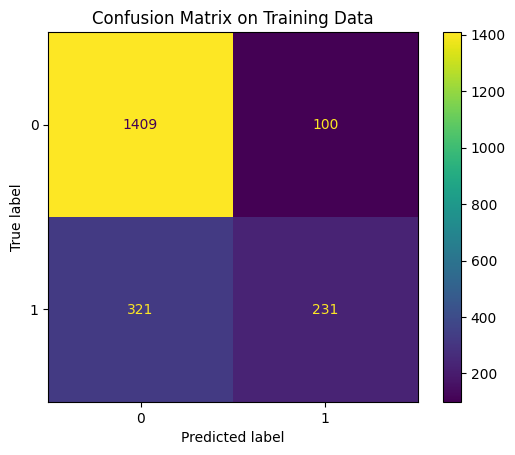

In [81]:

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix on Training Data')


10.Regression

10.1 Train/Test Sets

In [82]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [83]:

# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)


10.2. Model Selection

In [84]:

regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=42))
]

In [85]:

# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

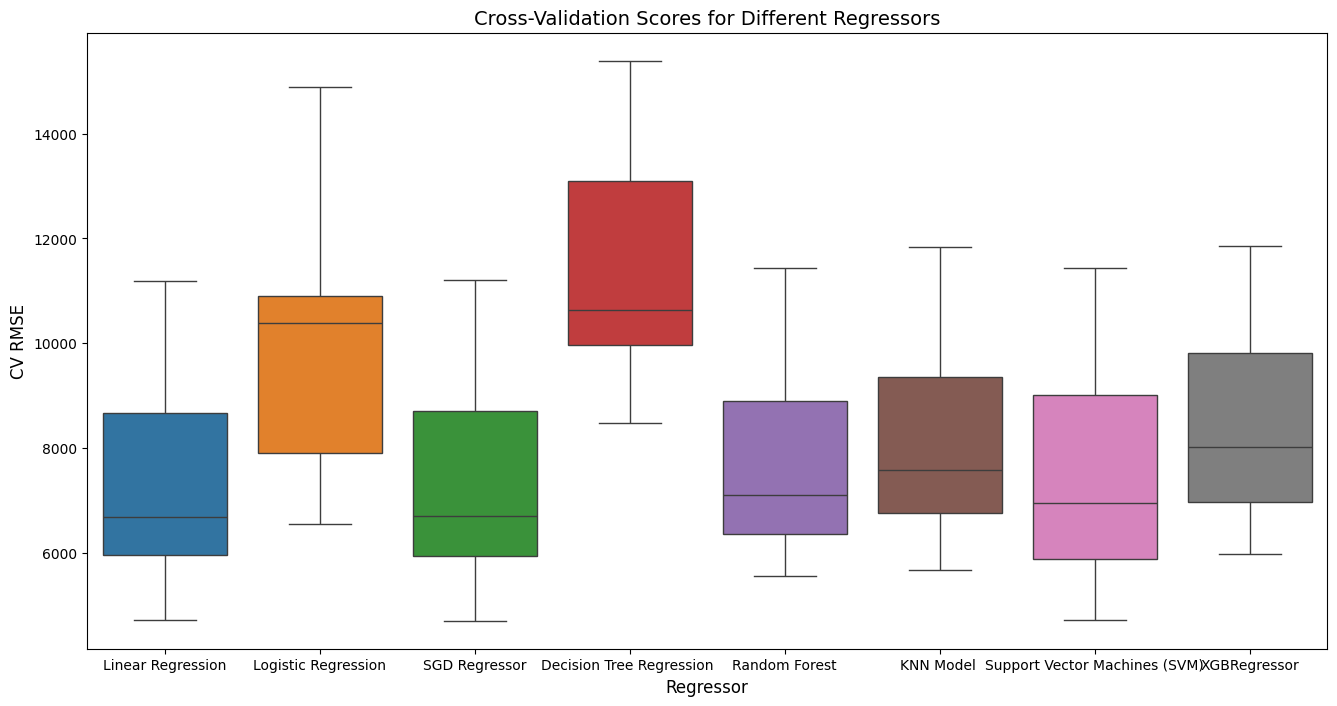

In [86]:

# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)


10.3. Hyperparameter Optimisation

In [87]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [88]:

# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.004, 0.008, 0.012],
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.003, 0.005],
    'max_iter': [180, 200, 220],
    'tol': [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [89]:
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits
Best parameters found:  {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}
Best cross-validation score:  7605.2923588743715
